In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# KePSH1 데이터 가져오기 

In [2]:
df1 = pd.read_csv('./211109_kepsh1.csv', parse_dates = True)

In [3]:
df1

,Unnamed: 0,Time,PV_kepsh1(W),PVT_kepsh1(W),Slope_solar_radiation(w/m2),FC(W),HP_kepsh1(W),Cons_kepsh1(W),Prod_kepsh1(W),ESS(W),...,PVT_acc_kepsh1(Wh),FC_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
0,158524,2021-09-13 00:00:00,0.0,9.0,0.0,0.0,29.0,677.0,9.0,-0.0,...,0.150000,0.000000,9.0,1.500000e-01,1.0,0.013294,1.000000,0.013294,0.013294,0.506647
1,158525,2021-09-13 00:03:00,0.0,9.0,0.0,0.0,29.0,674.0,9.0,-0.0,...,0.300000,0.000000,9.0,3.000000e-01,1.0,0.013353,1.000000,0.013323,0.013323,0.506662
2,158526,2021-09-13 00:04:00,0.0,9.0,0.0,0.0,29.0,780.0,9.0,-0.0,...,0.450000,0.000000,9.0,4.500000e-01,1.0,0.011538,1.000000,0.012670,0.012670,0.506335
3,158527,2021-09-13 00:05:00,0.0,9.0,0.0,0.0,28.0,806.0,9.0,-0.0,...,0.600000,0.000000,9.0,6.000000e-01,1.0,0.011166,1.000000,0.012257,0.012257,0.506129
4,158528,2021-09-13 00:06:00,0.0,9.0,0.0,0.0,29.0,797.0,9.0,-0.0,...,0.750000,0.000000,9.0,7.500000e-01,1.0,0.011292,1.000000,0.012051,0.012051,0.506026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65360,223885,2021-11-03 23:55:00,0.0,0.0,0.0,569.0,29.0,892.0,569.0,-0.0,...,83373.283333,164584.933333,569.0,1.367140e+06,1.0,0.637892,0.511999,1.000000,1.953130,0.755999
65361,223886,2021-11-03 23:56:00,0.0,0.0,0.0,568.0,29.0,896.0,568.0,-0.0,...,83373.283333,164594.400000,568.0,1.367155e+06,1.0,0.633929,0.512003,1.000000,1.953115,0.756001
65362,223887,2021-11-03 23:57:00,0.0,0.0,0.0,568.0,29.0,897.0,568.0,-0.0,...,83373.283333,164603.866667,568.0,1.367170e+06,1.0,0.633222,0.512006,1.000000,1.953101,0.756003
65363,223888,2021-11-03 23:58:00,0.0,0.0,0.0,570.0,29.0,892.0,570.0,-0.0,...,83373.283333,164613.366667,570.0,1.367185e+06,1.0,0.639013,0.512010,1.000000,1.953086,0.756005


In [4]:
df1['Time']= pd.to_datetime(df1['Time'])

In [5]:
df1=df1.set_index('Time')

In [6]:
df1=df1.resample('1T').mean()

In [7]:
df1=df1.fillna(0)

In [8]:
df1

,Unnamed: 0,PV_kepsh1(W),PVT_kepsh1(W),Slope_solar_radiation(w/m2),FC(W),HP_kepsh1(W),Cons_kepsh1(W),Prod_kepsh1(W),ESS(W),Cons_acc_kepsh1(Wh),...,PVT_acc_kepsh1(Wh),FC_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,,,,,,
2021-09-13 00:00:00,158524.0,0.0,9.0,0.0,0.0,29.0,677.0,9.0,0.0,1.128333e+01,...,0.150000,0.000000,9.0,1.500000e-01,1.0,0.013294,1.000000,0.013294,0.013294,0.506647
2021-09-13 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.000000,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-13 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.000000,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-13 00:03:00,158525.0,0.0,9.0,0.0,0.0,29.0,674.0,9.0,0.0,2.251667e+01,...,0.300000,0.000000,9.0,3.000000e-01,1.0,0.013353,1.000000,0.013323,0.013323,0.506662
2021-09-13 00:04:00,158526.0,0.0,9.0,0.0,0.0,29.0,780.0,9.0,0.0,3.551667e+01,...,0.450000,0.000000,9.0,4.500000e-01,1.0,0.011538,1.000000,0.012670,0.012670,0.506335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,223885.0,0.0,0.0,0.0,569.0,29.0,892.0,569.0,0.0,1.367140e+06,...,83373.283333,164584.933333,569.0,1.367140e+06,1.0,0.637892,0.511999,1.000000,1.953130,0.755999
2021-11-03 23:56:00,223886.0,0.0,0.0,0.0,568.0,29.0,896.0,568.0,0.0,1.367155e+06,...,83373.283333,164594.400000,568.0,1.367155e+06,1.0,0.633929,0.512003,1.000000,1.953115,0.756001
2021-11-03 23:57:00,223887.0,0.0,0.0,0.0,568.0,29.0,897.0,568.0,0.0,1.367170e+06,...,83373.283333,164603.866667,568.0,1.367170e+06,1.0,0.633222,0.512006,1.000000,1.953101,0.756003


# KePSH2 데이터 가져오기 

In [9]:
df2 = pd.read_csv('./211109_kepsh2.csv', parse_dates = True)

In [10]:
df2['Time']= pd.to_datetime(df2['Time'])

In [11]:
df2=df2.set_index('Time')

In [12]:
df2=df2.resample('1T').mean()

In [13]:
df2=df2.fillna(0)

In [14]:
df2

,PV_kepsh2(W),PVT_kepsh2(W),HP_kepsh2(W),Cons_kepsh2(W),Prod_kepsh2(W),Cons_acc_kepsh2(Wh),Prod_acc_kepsh2(Wh),PV_acc_kepsh2(Wh),PVT_acc_kepsh2(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,,
2021-09-13 00:00:00,0.0,1.0,6.0,299.0,1.0,4.983333e+00,1.666667e-02,0.000000e+00,0.016667,1.0,1.666667e-02,1.0,0.003344,1.000000,0.003344,0.003344,0.501672
2021-09-13 00:01:00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-13 00:02:00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-13 00:03:00,0.0,1.0,5.0,190.0,1.0,8.150000e+00,3.333333e-02,0.000000e+00,0.033333,1.0,3.333333e-02,1.0,0.005263,1.000000,0.004090,0.004090,0.502045
2021-09-13 00:04:00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,0.0,0.0,10.0,371.0,0.0,1.005112e+06,1.511982e+06,1.456512e+06,55462.700000,0.0,1.005112e+06,0.0,0.000000,0.664765,1.000000,1.504292,0.832382
2021-11-03 23:56:00,0.0,0.0,10.0,411.0,0.0,1.005119e+06,1.511982e+06,1.456512e+06,55462.700000,0.0,1.005119e+06,0.0,0.000000,0.664769,1.000000,1.504282,0.832385
2021-11-03 23:57:00,0.0,0.0,10.0,359.0,0.0,1.005125e+06,1.511982e+06,1.456512e+06,55462.700000,0.0,1.005125e+06,0.0,0.000000,0.664773,1.000000,1.504273,0.832387


# KPEB1 데이터 가져오기 

In [15]:
df3 = pd.read_csv('./211109_kpeb1.csv', parse_dates = True)

In [16]:
df3['Time']= pd.to_datetime(df3['Time'])

In [17]:
df3=df3.set_index('Time')

In [18]:
df3=df3.resample('1T').mean()

In [19]:
df3=df3.fillna(0)

In [20]:
df3

,Cons_kpeb1(W),Prod_kpeb1(W),Cons_acc_kpeb1(Wh),Prod_acc_kpeb1(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,
2021-09-13 00:00:00,5695.0,0.0,9.491667e+01,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000
2021-09-13 00:01:00,5284.0,0.0,1.829833e+02,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000
2021-09-13 00:02:00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000
2021-09-13 00:03:00,5551.0,0.0,2.755000e+02,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000
2021-09-13 00:04:00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,6076.0,0.0,8.487453e+06,5.437472e+06,0.0,5.437472e+06,0.0,0.0,1.0,0.640648,0.640648,0.820324
2021-11-03 23:56:00,6179.0,0.0,8.487556e+06,5.437472e+06,0.0,5.437472e+06,0.0,0.0,1.0,0.640640,0.640640,0.820320
2021-11-03 23:57:00,6468.0,0.0,8.487664e+06,5.437472e+06,0.0,5.437472e+06,0.0,0.0,1.0,0.640632,0.640632,0.820316


# KPEB2 데이터 가져오기 

In [21]:
df4 = pd.read_csv('./211109_kpeb2.csv', parse_dates = True)

In [22]:
df4['Time']= pd.to_datetime(df4['Time'])

In [23]:
df4=df4.set_index('Time')

In [24]:
df4=df4.resample('1T').mean()

In [25]:
df4=df4.fillna(0)

In [26]:
df4

,Cons_kpeb2(W),Prod_kpeb2(W),Cons_acc_kpeb2(Wh),Prod_acc_kpeb2(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,
2021-09-13 00:01:00,25.0,0.0,0.416667,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-13 00:02:00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-13 00:03:00,25.0,0.0,0.833333,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-13 00:04:00,25.0,0.0,1.250000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-13 00:05:00,24.0,1.0,1.650000,0.016667,1.0,0.016667,1.0,0.041667,1.000000,0.010101,0.010101,0.505051
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,122.0,0.0,107973.416667,647366.166667,0.0,107973.416667,0.0,0.000000,0.166789,1.000000,5.995607,0.583394
2021-11-03 23:56:00,123.0,0.0,107975.466667,647366.166667,0.0,107975.466667,0.0,0.000000,0.166792,1.000000,5.995493,0.583396
2021-11-03 23:57:00,127.0,0.0,107977.583333,647366.166667,0.0,107977.583333,0.0,0.000000,0.166795,1.000000,5.995376,0.583398


# KPEC 합치기

In [27]:
df_kpec = pd.DataFrame()
df_kpec = pd.DataFrame(pd.date_range('2021-09-13 00:00:00', '2021-11-03 23:59:00', freq='T'), columns=['Time'])

In [28]:
df_kpec

,Time
0,2021-09-13 00:00:00
1,2021-09-13 00:01:00
2,2021-09-13 00:02:00
3,2021-09-13 00:03:00
4,2021-09-13 00:04:00
...,...
74875,2021-11-03 23:55:00
74876,2021-11-03 23:56:00
74877,2021-11-03 23:57:00
74878,2021-11-03 23:58:00


In [29]:
df_kpec = df_kpec.set_index('Time')

In [30]:
df_kpec['Cons_kpec(W)'] = df1['Cons_kepsh1(W)'] + df2['Cons_kepsh2(W)'] + df3['Cons_kpeb1(W)'] + df4['Cons_kpeb2(W)']
df_kpec['Prod_kpec(W)'] = df1['Prod_kepsh1(W)'] + df2['Prod_kepsh2(W)'] + df3['Prod_kpeb1(W)'] + df4['Prod_kpeb2(W)']
df_kpec['ESS_kpec(W)'] = df1['ESS(W)']

In [31]:
df_kpec['ToGrid(W)'] = np.where((df_kpec['Prod_kpec(W)'] -df_kpec['Cons_kpec(W)']-df_kpec['ESS_kpec(W)'])<0, 0,(df_kpec['Prod_kpec(W)'] -df_kpec['Cons_kpec(W)']-df_kpec['ESS_kpec(W)']) )

In [32]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),ToGrid(W)
Time,,,,
2021-09-13 00:00:00,NaN,NaN,0.0,NaN
2021-09-13 00:01:00,5309.0,0.0,0.0,0.0
2021-09-13 00:02:00,0.0,0.0,0.0,0.0
2021-09-13 00:03:00,6440.0,10.0,0.0,0.0
2021-09-13 00:04:00,805.0,9.0,0.0,0.0
...,...,...,...,...
2021-11-03 23:55:00,7461.0,569.0,0.0,0.0
2021-11-03 23:56:00,7609.0,568.0,0.0,0.0
2021-11-03 23:57:00,7851.0,568.0,0.0,0.0


In [33]:
df_kpec = df_kpec[df_kpec['Cons_kpec(W)']< 40000]

In [34]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),ToGrid(W)
Time,,,,
2021-09-13 00:01:00,5309.0,0.0,0.0,0.0
2021-09-13 00:02:00,0.0,0.0,0.0,0.0
2021-09-13 00:03:00,6440.0,10.0,0.0,0.0
2021-09-13 00:04:00,805.0,9.0,0.0,0.0
2021-09-13 00:05:00,830.0,10.0,0.0,0.0
...,...,...,...,...
2021-11-03 23:55:00,7461.0,569.0,0.0,0.0
2021-11-03 23:56:00,7609.0,568.0,0.0,0.0
2021-11-03 23:57:00,7851.0,568.0,0.0,0.0


In [35]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74879 entries, 2021-09-13 00:01:00 to 2021-11-03 23:59:00
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cons_kpec(W)  74879 non-null  float64
 1   Prod_kpec(W)  74879 non-null  float64
 2   ESS_kpec(W)   74879 non-null  float64
 3   ToGrid(W)     74879 non-null  float64
dtypes: float64(4)
memory usage: 2.9 MB


In [36]:
df_kpec['Cons_acc_kpec(Wh)'] = df_kpec['Cons_kpec(W)'].cumsum()*60*1/3600
df_kpec['Prod_acc_kpec(Wh)'] = df_kpec['Prod_kpec(W)'].cumsum()*60*1/3600
df_kpec['ESS_acc_kpec(Wh)'] = df_kpec['ESS_kpec(W)'].cumsum()*60*1/3600
df_kpec['ToGrid_acc(Wh)'] = df_kpec['ToGrid(W)'].cumsum()*60*1/3600

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [37]:
df_kpec['E_self(W)'] = df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'] - df_kpec['ToGrid(W)']
df_kpec['E_self_acc(Wh)'] =df_kpec['E_self(W)'].cumsum()*60*1/3600

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
df_kpec['denominator'] = df_kpec.loc[:,['E_self(W)','Cons_kpec(W)']].min(axis=1)
df_kpec['denominator_acc'] = df_kpec.loc[:,['E_self_acc(Wh)','Cons_acc_kpec(Wh)']].min(axis=1)

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
df_kpec['SCF'] = df_kpec['denominator']/(df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'])
df_kpec['LCF'] = df_kpec['denominator']/df_kpec['Cons_kpec(W)']

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
df_kpec['SCF_acc'] = df_kpec['denominator_acc']/(df_kpec['Prod_acc_kpec(Wh)'] - df_kpec['ESS_acc_kpec(Wh)'])
df_kpec['LCF_acc'] = df_kpec['denominator_acc']/df_kpec['Cons_acc_kpec(Wh)']

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
df_kpec['self_sustain'] = df_kpec['Prod_acc_kpec(Wh)']/df_kpec['Cons_acc_kpec(Wh)']
df_kpec['Avg_SCF&LCF']=(df_kpec['SCF_acc']+df_kpec['LCF_acc'])/2

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74879 entries, 2021-09-13 00:01:00 to 2021-11-03 23:59:00
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cons_kpec(W)       74879 non-null  float64
 1   Prod_kpec(W)       74879 non-null  float64
 2   ESS_kpec(W)        74879 non-null  float64
 3   ToGrid(W)          74879 non-null  float64
 4   Cons_acc_kpec(Wh)  74879 non-null  float64
 5   Prod_acc_kpec(Wh)  74879 non-null  float64
 6   ESS_acc_kpec(Wh)   74879 non-null  float64
 7   ToGrid_acc(Wh)     74879 non-null  float64
 8   E_self(W)          74879 non-null  float64
 9   E_self_acc(Wh)     74879 non-null  float64
 10  denominator        74879 non-null  float64
 11  denominator_acc    74879 non-null  float64
 12  SCF                57300 non-null  float64
 13  LCF                66349 non-null  float64
 14  SCF_acc            74877 non-null  float64
 15  LCF_acc            74879 non-null  

In [43]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),ToGrid(W),Cons_acc_kpec(Wh),Prod_acc_kpec(Wh),ESS_acc_kpec(Wh),ToGrid_acc(Wh),E_self(W),E_self_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,,,
2021-09-13 00:01:00,5309.0,0.0,0.0,0.0,8.848333e+01,0.000000e+00,0.0000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:02:00,0.0,0.0,0.0,0.0,8.848333e+01,0.000000e+00,0.0000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,NaN
2021-09-13 00:03:00,6440.0,10.0,0.0,0.0,1.958167e+02,1.666667e-01,0.0000,0.000000e+00,10.0,1.666667e-01,10.0,1.666667e-01,1.0,0.001553,1.000000,0.000851,0.000851,0.500426
2021-09-13 00:04:00,805.0,9.0,0.0,0.0,2.092333e+02,3.166667e-01,0.0000,0.000000e+00,9.0,3.166667e-01,9.0,3.166667e-01,1.0,0.011180,1.000000,0.001513,0.001513,0.500757
2021-09-13 00:05:00,830.0,10.0,0.0,0.0,2.230667e+02,4.833333e-01,0.0000,0.000000e+00,10.0,4.833333e-01,10.0,4.833333e-01,1.0,0.012048,1.000000,0.002167,0.002167,0.501083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,7461.0,569.0,0.0,0.0,1.096757e+07,1.026702e+07,13266.6073,5.644444e+06,569.0,4.609311e+06,569.0,4.609311e+06,1.0,0.076263,0.449524,0.420267,0.936126,0.434896
2021-11-03 23:56:00,7609.0,568.0,0.0,0.0,1.096769e+07,1.026703e+07,13266.6073,5.644444e+06,568.0,4.609320e+06,568.0,4.609320e+06,1.0,0.074648,0.449525,0.420263,0.936116,0.434894
2021-11-03 23:57:00,7851.0,568.0,0.0,0.0,1.096782e+07,1.026704e+07,13266.6073,5.644444e+06,568.0,4.609329e+06,568.0,4.609329e+06,1.0,0.072347,0.449525,0.420259,0.936105,0.434892


In [44]:
df_kpec.to_csv('./211109_kpec_sumver.csv')

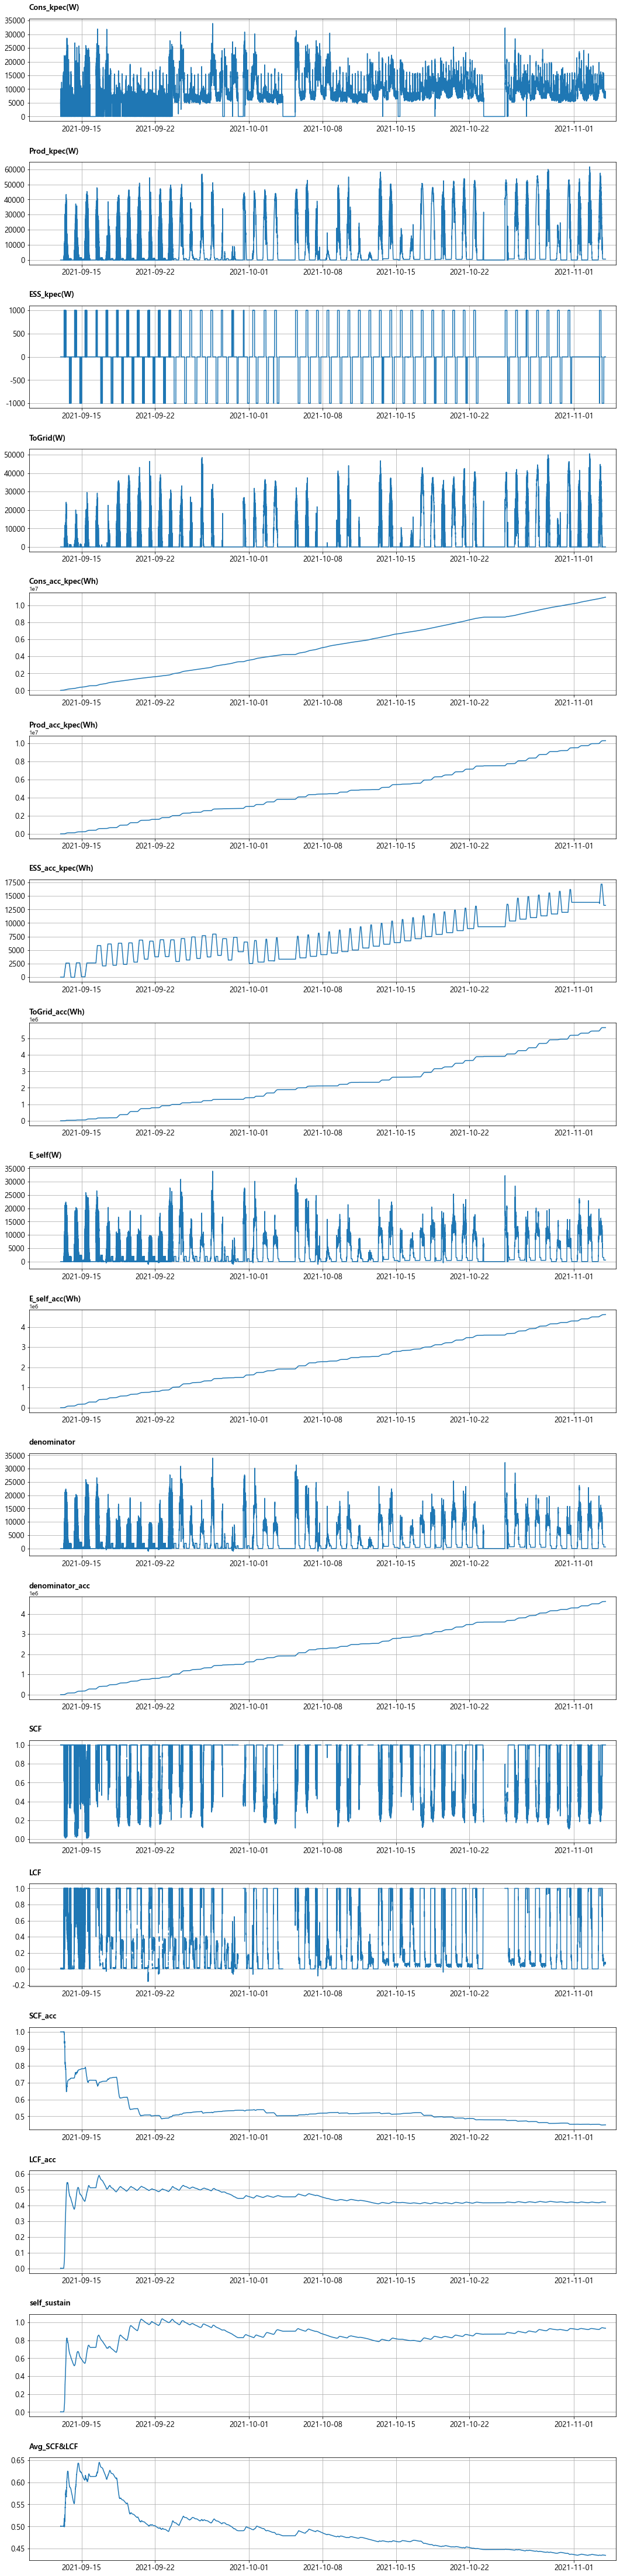

In [51]:
fig, ax = plt.subplots(figsize=(18,80))

for i in range(len(df_kpec.columns)):
    plt.subplot(len(df_kpec.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpec.columns[i]
    plt.plot(df_kpec[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [47]:
df = pd.read_csv('./211109_kpec_sumver.csv', parse_dates = True)

In [48]:
df

,Time,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),ToGrid(W),Cons_acc_kpec(Wh),Prod_acc_kpec(Wh),ESS_acc_kpec(Wh),ToGrid_acc(Wh),E_self(W),E_self_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
0,2021-09-13 00:01:00,5309.0,0.0,0.0,0.0,8.848333e+01,0.000000e+00,0.0000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,NaN,0.000000,NaN,0.000000,0.000000,NaN
1,2021-09-13 00:02:00,0.0,0.0,0.0,0.0,8.848333e+01,0.000000e+00,0.0000,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,NaN
2,2021-09-13 00:03:00,6440.0,10.0,0.0,0.0,1.958167e+02,1.666667e-01,0.0000,0.000000e+00,10.0,1.666667e-01,10.0,1.666667e-01,1.0,0.001553,1.000000,0.000851,0.000851,0.500426
3,2021-09-13 00:04:00,805.0,9.0,0.0,0.0,2.092333e+02,3.166667e-01,0.0000,0.000000e+00,9.0,3.166667e-01,9.0,3.166667e-01,1.0,0.011180,1.000000,0.001513,0.001513,0.500757
4,2021-09-13 00:05:00,830.0,10.0,0.0,0.0,2.230667e+02,4.833333e-01,0.0000,0.000000e+00,10.0,4.833333e-01,10.0,4.833333e-01,1.0,0.012048,1.000000,0.002167,0.002167,0.501083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74874,2021-11-03 23:55:00,7461.0,569.0,0.0,0.0,1.096757e+07,1.026702e+07,13266.6073,5.644444e+06,569.0,4.609311e+06,569.0,4.609311e+06,1.0,0.076263,0.449524,0.420267,0.936126,0.434896
74875,2021-11-03 23:56:00,7609.0,568.0,0.0,0.0,1.096769e+07,1.026703e+07,13266.6073,5.644444e+06,568.0,4.609320e+06,568.0,4.609320e+06,1.0,0.074648,0.449525,0.420263,0.936116,0.434894
74876,2021-11-03 23:57:00,7851.0,568.0,0.0,0.0,1.096782e+07,1.026704e+07,13266.6073,5.644444e+06,568.0,4.609329e+06,568.0,4.609329e+06,1.0,0.072347,0.449525,0.420259,0.936105,0.434892
74877,2021-11-03 23:58:00,7908.0,570.0,0.0,0.0,1.096796e+07,1.026705e+07,13266.6073,5.644444e+06,570.0,4.609339e+06,570.0,4.609339e+06,1.0,0.072079,0.449526,0.420255,0.936095,0.434890


In [49]:
df['Time']= pd.to_datetime(df['Time'])

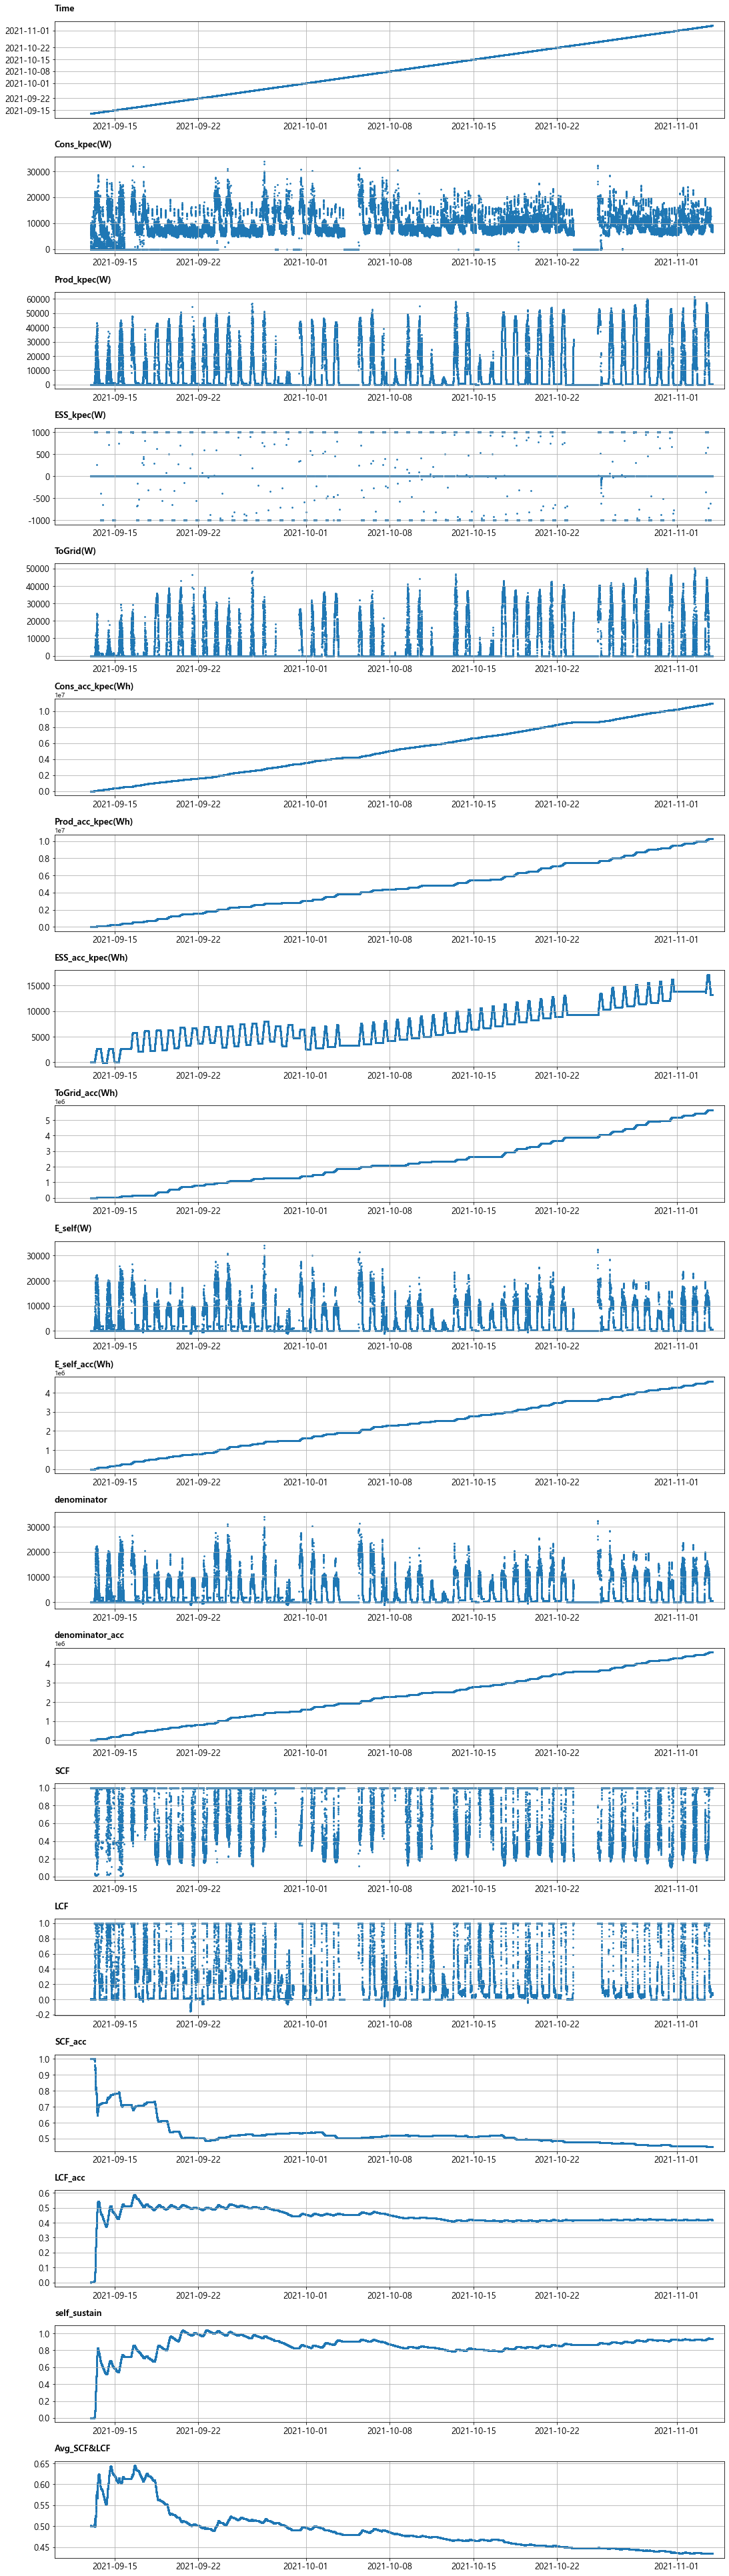

In [50]:
fig, ax = plt.subplots(figsize=(18,70))


for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    name = df.columns[i]
    plt.scatter(x=df['Time'], y=df[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()